# Probabilistic Models – Spring 2021
## Exercise Session 4
Feb 17rd 16.15

<span style="color:red">**Carmen Diez**</span>

### Instructions
Make sure the notebook produces correct results when ran sequentially starting from the first cell. You can ensure this by clearing all outputs (`Edit > Clear All Outputs`), running all cells (`Run > Run All Cells`), and finally correcting any errors.

To get points:
1. Submit your answers to the automatically checked Moodle test. 
 - You have 5 tries on the test: the highest obtained score will be taken into account.
 - For numerical questions the tolerance is $1\cdot10^{-4}$.
2. Submit this notebook containing your derivations to Moodle.

**Exercises 3, 5 and 6 are checked completely manually: in the corresponding Moodle questions return "1" if you have done the exercise. The points that you get for the exercises are then subject to change as we check the notebooks. Also your notebooks for the other problems will be checked, so that for example in 1 you used the asked algorithm, instead of computing the value through the joint distribution.**

## Exercise 1
***

Compute $P(C,D)$ for the following BN using plain factor elimination without network pruning.

![](4.1.svg)

The factors for the BN are:

In [1]:
!for v in {A..E}; do echo "data/f"$v".tsv"; cat "data/f"$v".tsv"; echo ""; done

data/f{A..E}.tsv
cat: data/f{A..E}.tsv: No such file or directory



Report in Moodle $P(C=0, D=0)$.

You can implement the algorithm programmatically or just use it "on paper". 

### Solution

In [2]:
import numpy as np
import pandas as pd

In [3]:
def ini():
    fA = pd.read_csv('data/fA.tsv', sep = '\t')
    fB = pd.read_csv('data/fB.tsv', sep = '\t')
    fC = pd.read_csv('data/fC.tsv', sep = '\t')
    fD = pd.read_csv('data/fD.tsv', sep = '\t')
    fE = pd.read_csv('data/fE.tsv', sep = '\t')
    f = {'A':fA, 'B':fB, 'C':fC, 'D':fD, 'E':fE}
    return f
    
def mult(f1, f2):
    fres = f[f1].merge(f[f2], how='left')
    fres['f'+f1] = fres['f'+f1]*fres['f'+f2]
    fres = fres.drop(columns = 'f'+f2)
    return fres

def sumOut(f1, V):
    df = f[f1]
    if len(V)==0:
        return df
    cols = df.columns[:-1]
    colsOut = list(cols[[node not in V for node in cols]])
    fres = df.groupby(colsOut, as_index=False).sum().drop(columns = V)
    return fres 

def proj(f1, V):
    V = list(set(f[f1].columns[:-1]).difference(set(V)))
    return sumOut(f1, V)

The algorithm to get $P(C,D)$ can be applied this way:
* Preliminary stage:

$f_r \leftarrow f_D$

$Q\leftarrow \{C, D\}$

$S\leftarrow\{f_A,..,f_E\}$
 
* 1st iteration:

$f_i\leftarrow f_A(A)$

$S\leftarrow\{f_B,..,f_E\}$

$V\leftarrow\{\}$

$f_j\leftarrow f_C(A,B,C)$

$f_j\leftarrow f_j*f_i$
 
* 2nd Iteration

$f_i\leftarrow f_B(B)$

$S\leftarrow \{f_C,..,f_E\}$

$V\leftarrow \{\}$

$f_j\leftarrow f_C(A,B,C)$

$f_j\leftarrow f_j*f_i$

* 3rd Iteration

$f_i\leftarrow f_C(A,B,C)$

$S\leftarrow\{f_D, f_E\}$

$V\leftarrow\{A,B\}$

$f_j \leftarrow f_D(C,D)$

$f_j\leftarrow f_j*\sum_{V} f_i$

* 4th Iteration

$f_i\leftarrow f_E(C,E)$

$S\leftarrow \{f_D\}$

$V\leftarrow \{E\}$

$f_j\leftarrow f_D(C,D)$

$f_j\leftarrow f_j*\sum_{V} f_i$

* Final result

project$(f_r,Q)$

In [4]:
# preliminary stages
f=ini()
fr = 'D'

# 1st iteration 
fi = 'A'
fj = 'C'
f[fj] = mult(fj, fi)

# 2nd iteration 
fi = 'B'
fj = 'C'
f[fj] = mult(fj, fi)

# 3rd iteration 
fi = 'C'
V = ['A','B']
fj = 'D'
f[fi] = sumOut(fi, V)
f[fj] = mult(fj, fi)

# 4th iteration 
fi = 'E'
V = ['E']
fj = 'D'
f[fi] = sumOut(fi, V)
f[fj] = mult(fj, fi)

# final result
V=['C','D']
pCD = proj(fr, V)

print('P(C=0,D=0):', pCD[(pCD['C']==0) & (pCD['D']==0)]['fD'].item())
pCD

P(C=0,D=0): 0.09200000000000001


,C,D,fD
0,0,0,0.092
1,0,1,0.368
2,1,0,0.378
3,1,1,0.162


## Exercise 2
***

Based on your previous or upcoming calculation, what is $P(C|D=1)$?

### Solution

The algorithm follows the same steps as above adding the evidence $D=1$ to get $P(C, D=1)$ (we use the last result with $D=1$).

Then, $P(C|D=1)=\frac{P(C,D=1)}{P(D=1)}$

And $P(D=1)=\sum{C} P(C,D=1)$.

In [5]:
pCID1 = pCD[pCD['D']==1].copy()
pD1 = pCID1['fD'].sum()
pCID1['fDCond'] = pCID1['fD']/pD1
print('P(C=1|D=1):', pCID1[pCID1['C']==1]['fDCond'].item())
pCID1

P(C=1|D=1): 0.30566037735849055


,C,D,fD,fDCond
1,0,1,0.368,0.69434
3,1,1,0.162,0.30566


## Exercise 3
***

Consider the BN of task 1. One elimination tree for this DAG is given by the following. 

![](4.3.png)

Calculate all messages used by message passing factor elimination over the elimination tree.

Either compute the messages programmatically or manually. If you choose to compute them manually, please format them according to the following example (so that they are easy to check): 

$$
\begin{aligned}
M_{12} &= \text{proj}(\phi_1, \{A\}) = \text{proj}\left(
\begin{array}{c | l}
A & f_A \\ \hline
0 & 0.6 \\
1 &  0.4
\end{array}, \{A\}
\right) \\
&= 
\begin{array}{c | l}
A & f_A \\ \hline
0 & 0.6 \\
1 & 0.4
\end{array}
\end{aligned}
$$


### Solution

In [6]:
#Same functions as before, taking df as parameter instead of letter
def multPass(f1, f2):
    fres = f1.merge(f2, how='left')
    fres.iloc[:,-2] = fres.iloc[:,-1]*fres.iloc[:,-2]
    fres = fres.iloc[:,:-1]
    return fres

def sumOutPass(f1, V):
    if len(V)==0:
        return f1
    cols = f1.columns[:-1]
    colsOut = list(cols[[node not in V for node in cols]])
    fres = f1.groupby(colsOut, as_index=False).sum().drop(columns = V)
    return fres 

def projPass(f1, V):
    V = list(set(f1.columns[:-1]).difference(set(V)))
    return sumOutPass(f1, V)

Root = 2, message calculation as follows:

$M_{ij} =$project$(\phi_i*\prod_{k\neq j}M_{ki}, S_{ij})$

For the way the tree is, pulling $M_{ij} =$project$(\phi_i, S_{ij})$ and pushing with the above formula.

In [7]:
# Message passing
# Initiate 
f = ini()
phi1 = f['A']
phi2 = multPass(f['C'], f['B'])
phi3 = f['D']
phi4 = f['E']

# Pull messages towards root
M12 = projPass(phi1, ['A'])
M32 = projPass(phi3, ['C'])
M42 = projPass(phi4, ['C'])

# Push messages away
# M32 and M42 are the identity so we dont multiply them
M21 = projPass(phi2, ['A']) #no need M32 and M42
M23 = projPass(multPass(phi2, M12), ['C']) #no need M42
M24 = projPass(multPass(phi2, M12), ['C']) #no need M32


print('M12 \n', M12, '\n')
print('M32 \n', M32, '\n')
print('M42 \n', M42, '\n')
print('M21 \n', M21, '\n')
print('M23 \n', M23, '\n')
print('M24 \n', M24, '\n')

M12 
    A   fA
0  0  0.6
1  1  0.4 

M32 
    C   fD
0  0  1.0
1  1  1.0 

M42 
    C   fE
0  0  1.0
1  1  1.0 

M21 
    A   fC
0  0  1.0
1  1  1.0 

M23 
    C    fC
0  0  0.46
1  1  0.54 

M24 
    C    fC
0  0  0.46
1  1  0.54 



## Exercise 4
***

Concerning the message passing factor elimination run in the previous task, calculate the cluster marginals. Check that all agree with $P(C)$.

From the computed cluster marginals report
- $P(A=0)$
- $P(C=1, D=0)$
- $P(C=0, E=1)$
- $P(A=1, B=0, C=1)$

### Solution

Corresponding $\phi_i$ multiplied by messages pulled (all but root) or pushed (root).

**All:**

$P(A)=\phi_1*M_{21}$,

$P(C,D)=\phi_3*M_{23}$

$P(C,E)=\phi_4*M_{24}$

**Root:**

$P(A,B,C)=\phi_2*M_{12}*M_{32}*M_{42}=\phi_2*M_{12}$ 
  as $M_{32}=M_{42}=1$.

In [8]:
pA = multPass(phi1, M21)
pCD = multPass(phi3, M23)
pDE = multPass(phi4, M24)
pABC = multPass(phi2, M12)

print('P(A):\n', pA)
print('\nP(C,D):\n', pCD)
print('\nP(C,E):\n', pDE)
print('\nP(A,B,C):\n', pABC)
print()
print('P(A=0):', pA[pA['A']==0]['fA'].item())
print('P(C=1,D=0):', pCD[(pCD['C']==1) & (pCD['D']==0)]['fD'].item())
print('P(C=0,E=1):', pDE[(pDE['C']==0) & (pDE['E']==1)]['fE'].item())
print('P(A=1,B=0,C=1):', pABC[(pABC['A']==1) & (pABC['B']==0) & (pABC['C']==1)]['fC'].item())

P(A):
    A   fA
0  0  0.6
1  1  0.4

P(C,D):
    C  D     fD
0  0  0  0.092
1  0  1  0.368
2  1  0  0.378
3  1  1  0.162

P(C,E):
    C  E     fE
0  0  0  0.046
1  0  1  0.414
2  1  0  0.108
3  1  1  0.432

P(A,B,C):
    A  B  C    fC
0  0  0  0  0.27
1  0  0  1  0.03
2  0  1  0  0.03
3  0  1  1  0.27
4  1  0  0  0.10
5  1  0  1  0.10
6  1  1  0  0.06
7  1  1  1  0.14

P(A=0): 0.6
P(C=1,D=0): 0.378
P(C=0,E=1): 0.41400000000000003
P(A=1,B=0,C=1): 0.1


## Exercise 5
***

Find a jointree for the following DAG. Mark the clusters, separators and factors. How does the tree change if you want to calculate $P(A,E)$ (i.e., if $A$ and $E$ have to appear in the same cluster)?

![](4.5.1.svg)

You can draw the jointree using which ever tool and then embed the image to the notebook (check this cell for an example on how to embed images). Alternatively, install the [Python interface to graphviz](https://graphviz.readthedocs.io/en/stable/manual.html) and [graphviz](https://www.graphviz.org/) itself. After successful installation, running the next cell (which you can use as an example) should output the following image:

![](4.5.2.svg)

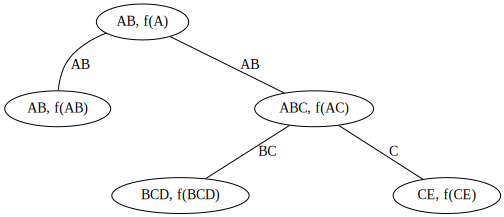

In [9]:
# Graphviz example

import graphviz

g = graphviz.Graph(engine='dot', 
                   graph_attr={'rankdir':'TB', 
                               'size':'7', 'nodesep':'2'})

g.node("AB, f(A)")
g.node("AB, f(AB)")
g.node("ABC, f(AC)")
g.node("BCD, f(BCD)")
g.node("CE, f(CE)")

g.edge("AB, f(A)", "AB, f(AB)", label="AB")
g.edge("AB, f(A)", "ABC, f(AC)", label="AB")
g.edge("ABC, f(AC)", "BCD, f(BCD)", label="BC")
g.edge("ABC, f(AC)", "CE, f(CE)", label="C")

g

## Solution

### Steps for a jointree
0. Graph to graphviz (**undirected already for next step**).

1. Moralizing $G$ to create $M_G$.
  * Add an undirected edge between every pair of variables that have a common child (marry the parents).
  * Make all edges undirected.
  
2. Triangulating $M_G$ to create $T_G$.
  * Add a chord (edge) to each cycle of length greater than 3. **In this case, there is no cycle of length greater than 3.**
  
3. Extracting maximal cliques from $T_G$.
  * The (maximal) cliques (nodes all connected to each other) in the triangulated graph are the clusters in the jointree.

    
4. Assembling the cliques into a join tree $J_T$.
  * Added edges between clusters such that:
    - The running intersection property is satisfied: If a node appears in clusters $C_i$ and $C_j$, it appears in every cluster on the path (there is one!) connecting the clusters. **The running intersection holds, as it can easily be visually seen.**.
    - It is a tree, i.e. singly connected. **It holds, too.**


In [10]:
import graphviz

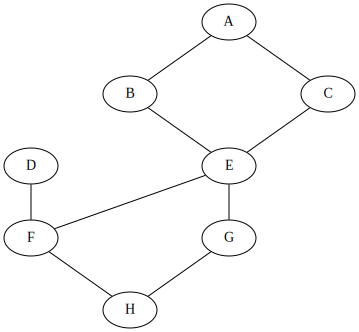

In [11]:
#0
g = graphviz.Graph(engine='dot', 
                   graph_attr={'rankdir':'TB', 
                               'size':'20', 'nodesep':'2'})
g.node("A")
g.node("B")
g.node("C")
g.node("D")
g.node("E")
g.node("F")
g.node("G")
g.node("H")

g.edge("A","B")
g.edge("A","C")
g.edge("B","E")
g.edge("C","E")
g.edge("E","F")
g.edge("E","G")
g.edge("D","F")
g.edge("F","H")
g.edge("G","H")

g

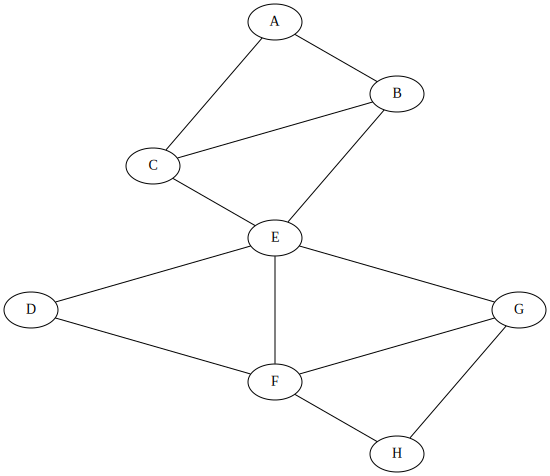

In [12]:
#1
g.edge("B","C")
g.edge("E","D")
g.edge("G","F")

g

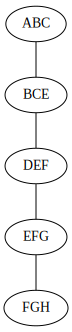

In [13]:
#3
g = graphviz.Graph(engine='dot', 
                   graph_attr={'rankdir':'TB', 
                               'size':'20', 'nodesep':'2'})

g.node("ABC")
g.node("BCE")
g.node("DEF")
g.node("EFG")
g.node("FGH")

g.edge("ABC", "BCE")
g.edge("BCE", "DEF")
g.edge("DEF", "EFG")
g.edge("EFG", "FGH")

g

### Clusters, separators and factors

* **Separator**: intersection of variables that occur on the i side of the edge and on the j side of the edge (on the whole tree!). **On the graph**.

* **Clusters**: the (maximal) cliques (nodes all connected to each other) in the triangulated graph are the clusters in the jointree. **Calculated before, the graph stays the same.**

* **Factors**: we can have the following:

$\phi_1 = f_A(A), f_B(A,B), f_C(A,C)$

$\phi_2 = f_E(B,C,E)$

$\phi_3 = f_D(D), f_F(D,E,F)$

$\phi_4 = f_G(E,G)$

$\phi_5 = f_H(F,G,H)$

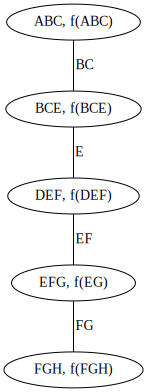

In [14]:
g = graphviz.Graph(engine='dot', 
                   graph_attr={'rankdir':'TB', 
                               'size':'20', 'nodesep':'2'})

g.node("ABC, f(ABC)")
g.node("BCE, f(BCE)")
g.node("DEF, f(DEF)")
g.node("EFG, f(EG)")
g.node("FGH, f(FGH)")

g.edge("ABC, f(ABC)", "BCE, f(BCE)", label = 'BC')
g.edge("BCE, f(BCE)", "DEF, f(DEF)", label = 'E')
g.edge("DEF, f(DEF)", "EFG, f(EG)", label = 'EF')
g.edge("EFG, f(EG)", "FGH, f(FGH)", label = 'FG')

g

### Modify tree if $A$ and $E$ have to appear in the same cluster

* **Separator**: intersection of variables that occur on the i side of the edge and on the j side of the edge (on the whole tree!). **On the new graph**.

* **Clusters**: **Calculated such that $A$ and $E$ appear in the same cluster. On the new graph**.

* **Factors**: we can have the following with the new clusters:

$\phi_1 = f_A(A), f_C(A,C), f_E(B,C,E)$ (*changed*)

$\phi_2 = f_B(A,B)$ (*changed*)

$\phi_3 = f_D(D), f_F(D,E,F)$

$\phi_4 = f_G(E,G)$

$\phi_5 = f_H(F,G,H)$

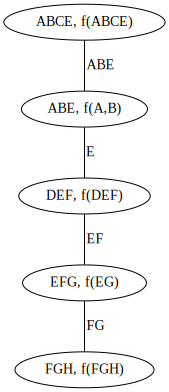

In [15]:
g = graphviz.Graph(engine='dot', 
                   graph_attr={'rankdir':'TB', 
                               'size':'20', 'nodesep':'2'})

g.node("ABCE, f(ABCE)")
g.node("ABE, f(A,B)")
g.node("DEF, f(DEF)")
g.node("EFG, f(EG)")
g.node("FGH, f(FGH)")

g.edge("ABCE, f(ABCE)", "ABE, f(A,B)", label = 'ABE')
g.edge("ABE, f(A,B)", "DEF, f(DEF)", label = 'E')
g.edge("DEF, f(DEF)", "EFG, f(EG)", label = 'EF')
g.edge("EFG, f(EG)", "FGH, f(FGH)", label = 'FG')

g

## Exercise 6
***

Prune the following DAG with respect to query $P(B,E \mid A=T)$.

![](4.6.svg)

Again, draw the pruned DAG in steps explaining each action, using which ever tool (e.g., graphviz).

### Solution

Query $Q=\{B,E\}$ and evidence $E=\{A\}$. Factorization: $P(A,B,C,D,E,F,G,H) = P(A)P(B|A)P(C|A)P(D|B)P(E|C)P(F|D)P(G|E)P(H|F,G)$

1. We can prune out leaves separate from $Q$ and $E$: $D,F,G,H$.

2. For any $U \in E$:
  1. Remove edge $U\rightarrow X$: $A\rightarrow B$ and $A\rightarrow C$ removed.
  2. Replace $P(X|Pa(X))$ with a simplified CPD $P(X|Pa(X) \ U)$ taking evidence into account: $P(B|A) \rightarrow P(B)$ and $P(C|A) \rightarrow P(C)$ taking $A=T$ into account.

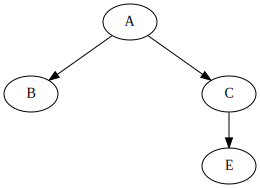

In [16]:
#1
g = graphviz.Digraph(engine='dot', 
                   graph_attr={'rankdir':'TB', 
                               'size':'20', 'nodesep':'2'})
g.node("A")
g.node("B")
g.node("C")
g.node("E")

g.edge("A","B")
g.edge("A","C")
g.edge("C","E")

g

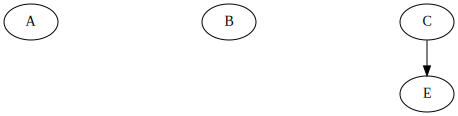

In [17]:
#2
g = graphviz.Digraph(engine='dot', 
                   graph_attr={'rankdir':'TB', 
                               'size':'20', 'nodesep':'2'})
g.node("A")
g.node("B")
g.node("C")
g.node("E")

g.edge("C","E")

g